In [2]:
using DataTables
using Plots
using StatsBase
using Distributions
using StatsFuns
using KernelDensity
using Statistics
using StatsPlots
using CSV
using DataFrames
using LaTeXStrings
using LsqFit
using DelimitedFiles

In [4]:
cars = [126, 134, 156, 124, 161, 129, 154, 150, 151, 153, 123, 125, 116, 115, 139, 106, 98, 107, 108, 114, 104, 93, 119, 82]
data = [[1,12.72,12],
        [2,6.98,8],
        [3,14.69,8],
        [4,9.38,10],
        [5,11.27,11],
        [6,13.43,11],
        [7,11.79,12],
        [8,8.68,11],
        [9,7.20,9],
        [10,8.64,9],
        [11,11.04,10],
        [12,11.58,11],
        [13,12.71,10],
        [14,13.39,11],
        [15,13.29,9],
        [16,6.28,8],
        [17,11.04,9],
        [18,9.05,8],
        [19,12.16,9],
        [20,9.15,8]]
df = DataFrame(index=Int64[], time=Float64[], cars=Int64[])
push!.(Ref(df), data)
df

20×3 DataFrame
 Row │ index  time     cars  
     │ Int64  Float64  Int64 
─────┼───────────────────────
   1 │     1    12.72     12
   2 │     2     6.98      8
   3 │     3    14.69      8
   4 │     4     9.38     10
   5 │     5    11.27     11
   6 │     6    13.43     11
   7 │     7    11.79     12
   8 │     8     8.68     11
  ⋮  │   ⋮       ⋮       ⋮
  14 │    14    13.39     11
  15 │    15    13.29      9
  16 │    16     6.28      8
  17 │    17    11.04      9
  18 │    18     9.05      8
  19 │    19    12.16      9
  20 │    20     9.15      8
               5 rows omitted

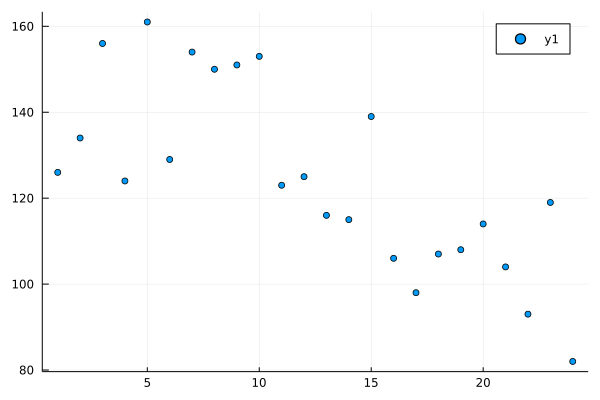

In [7]:
scatter(cars)

In [9]:
function MA(X, n)
    S = Float64[]
    for i in 1 : length(X) - n + 1
        s = mean(X[i : i + n - 1])
        append!(S, s)
    end
    return S
end

MA (generic function with 1 method)

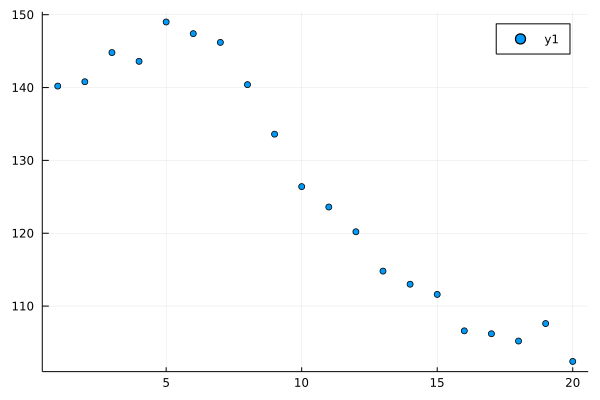

In [10]:
scatter(MA(cars, 5))

$$ n(t) = a_3 t^3 + a_2 t^2 + a_1 t + a_0 $$

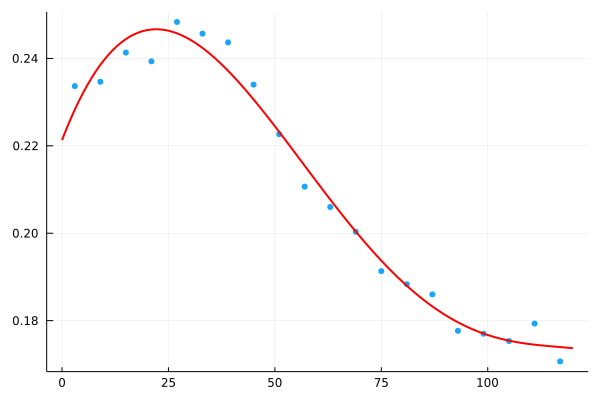

a0 = 0.22132420713278783
a1 = 0.0025363686292275314
a2 = -7.402162178624882e-5
a3 = 5.074937646002667e-7
a4 = -6.5520604879903494e-12


In [59]:
X = 3:6:117
Y = MA(cars, 5) ./ 600

f_mod(t, p) = p[5] .* t.^5 .+ p[4] .* t.^3 .+ p[3] .* t.^2 .+ p[2] .* t .+ p[1]
f_fit = curve_fit(f_mod, X, Y, [1.0, 1.0, 1.0, 1.0, 1.0])

xs = 0:1:120
scatter(X, Y, ms=4, alpha=0.9, markerstrokewidth=0, legend=false)
plot!(xs, f_mod(xs, f_fit.param), lw=2, c=:red) |> display

symbols = ["a0", "a1", "a2", "a3", "a4"]
for param in zip(symbols, f_fit.param) 
    println(param[1], " = ", param[2])
end

In [172]:
v_sr = 40
v_f = 70 / mean(df.time)
r = 70 / mean(df.cars)
n(t) = r/2 * f_mod(t/100, f_fit.param)
g(t) = n(t) / v_sr
p_Z = 3.7
function p(t, T, T_Z)
    if 0 < t % T <= T_Z
        return p_Z
    else
        return 0.0
    end
end

p (generic function with 1 method)

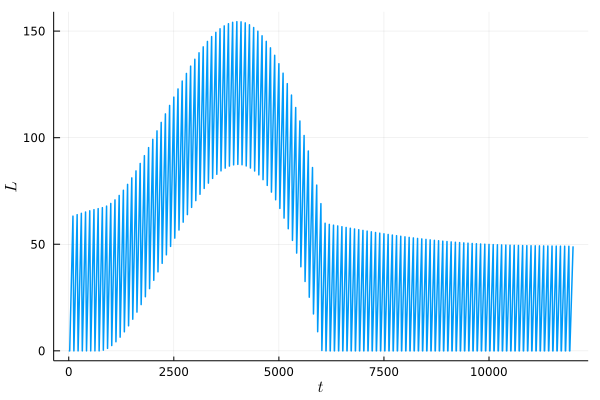

In [72]:
L0 = 0

dt = 1 # Krok czasowy
T = 12000

T_ZC = 100
T_Z = 23

# Wartości L'(t)
dL = dt .* (v_sr .* g.(dt:dt:T) .- p.(dt:dt:T, T_ZC, T_Z)) ./ (1 .- g.(dt:dt:T))

# Metodą Eulera wyliczamy wartości L(t)
Ls = [maximum([0, dL[1]])]
for t in 2dt:dt:T
    index = Int(round(t/dt))
    l = Ls[index-1] + dL[index]
    if l <= 0
        append!(Ls, 0)
    else
        append!(Ls, l)
    end
end

plot(dt:dt:T, Ls, xlabel=L"t", ylabel=L"L", label=L"L(t)", lw=1.5, legend=false) |> display

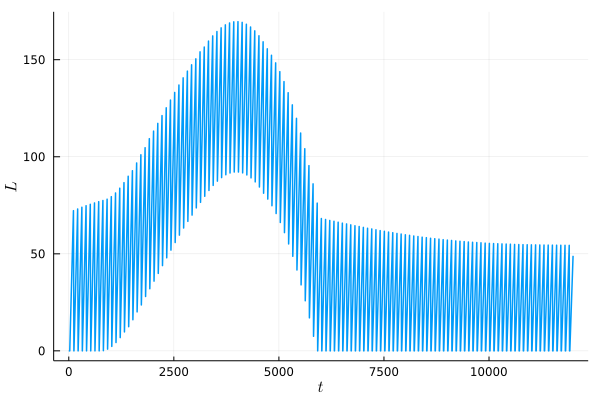

In [88]:
L0 = 0

dt = 0.1 # Krok czasowy
T = 12000

T_ZC = 100
T_Z = 23

# Wartości L'(t)
dL = dt .* (v_sr .* g.(dt:dt:T) .- p.(dt:dt:T, T_ZC, T_Z)) ./ (1 .- g.(dt:dt:T))

# Metodą Eulera wyliczamy wartości L(t)
Ls = Float64[L0]
for t in dt:dt:T-dt
    Δt = Ls[end]/v_f
    dL = dt * (v_sr * g(t - Δt) - p(t - Δt, T_ZC, T_Z)) / (1 - g(t - Δt) - p(t - Δt, T_ZC, T_Z)/v_f)
    l = Ls[end] + dL
    if l <= 0
        append!(Ls, 0)
    else
        append!(Ls, l)
    end
end

plot(dt:dt:T, Ls, xlabel=L"t", ylabel=L"L", label=L"L(t)", lw=1.5, legend=false) |> display

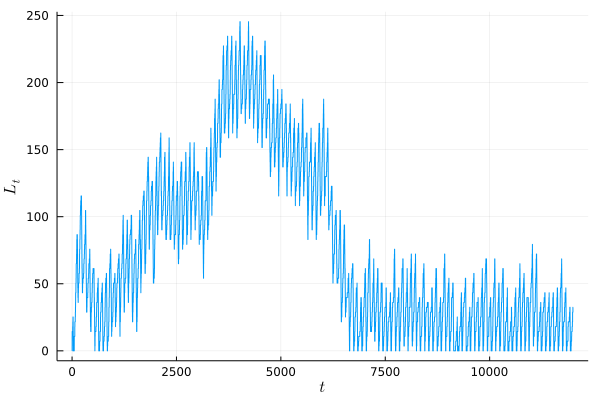

In [188]:
λ(t) = n(t) / (r/2)
λm = maximum(λ.(0:01:T))

T = 12000
Δt = 1/(2 * p_Z / r)
T_ZC = 100
T_Z = 24

Ts_N = sort(rand(Uniform(0, T), rand(Poisson(λm*T))))
Ts_N = [t for t in Ts_N if rand()<λ(t)/λm]
F_N = ecdf(Ts_N)
N(t) = F_N(t) * length(Ts_N)

Ts = Float64[]
for t in T_Z : T_ZC : T
    Ts = vcat(Ts, t + Δt : Δt : t + T_Z)
end

Ts_P = Float64[]
diffs = 0
for t in Ts
    if N(t) - diffs > 0.5
        diffs += 1
        append!(Ts_P, t)
    end
end

F_P = ecdf(Ts_P)
P(t) = F_P(t) * length(Ts_P)
L(t) = (N(t) - P(t)) * r/2

ts = 0:0.1:T
plot(ts, L.(ts), legend=false, xlabel=L"t", ylabel=L"L_t") |> display